# Math 189 Final Project

> load data and import necesary package below

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso
import statsmodels.api as sm

In [10]:
# Load the TSV file
file_path = 'cape.tsv'
data = pd.read_csv(file_path, sep='\t')
sp22 = pd.read_csv('SP22.tsv', sep = '\t')
s122 = pd.read_csv('S122.tsv', sep = '\t')
fa22 = pd.read_csv('FA22.tsv', sep = '\t')

# Display the first few rows of the dataframe
data = data[data['term'] == 'SP22']
data.head()

,instructor,sub_course,course,term,enroll,evals_made,rcmd_class,rcmd_instr,study_hr_wk,avg_grade_exp,avg_grade_rec
10,"Smith, Neil Gordon",ANAR 104,Intro GIS for Anth & Arch,SP22,10.0,6.0,100.0,100.0,3.83,4.00,-1.00
11,"Smith, Neil Gordon",ANAR 143,Biblical Arch,SP22,36.0,7.0,85.7,85.7,4.50,3.57,3.33
12,"D'Alpoim Guedes, Jade A",ANAR 146,Feeding the World,SP22,78.0,20.0,95.0,100.0,5.80,3.84,3.38
13,"Braswell, Geoffrey E.",ANAR 155,Stdy Abrd: Ancient Mesoamerica,SP22,23.0,16.0,100.0,100.0,2.63,3.94,3.97
14,"Goldstein, Paul S",ANAR 156,Archaeology of South America,SP22,36.0,10.0,80.0,100.0,4.30,3.70,3.81


In [11]:
# Rename the column 'old_column_name' to 'new_column_name'
sp22 = sp22.rename(columns={'subj_course_id': 'sub_course'})

# Display the merged DataFrame
sp22 = sp22[['sub_course', 'total_seats', 'meetings' ]]
sp22.head()

,sub_course,total_seats,meetings
0,AAS 10,34,"LE,TuTh,17:00 - 18:20,MANDE B-150|DI,M,15:00 -..."
1,AAS 10,34,"LE,TuTh,17:00 - 18:20,MANDE B-150|DI,W,16:00 -..."
2,AAS 190,44,"SE,TuTh,11:00 - 12:20,SOLIS 111"
3,AAS 198,20,"IN,N/A,0:00 - 0:00,TBA TBA"
4,AAS 500,2,"PR,N/A,0:00 - 0:00,TBA TBA"


In [12]:
# Function to extract class schedule
def extract_schedule(meetings):
    try:
        return meetings.split(',')[1]
    except IndexError:
        return None

# Function to calculate class length in minutes
def calculate_class_length(meetings):
    try:
        time_range = meetings.split(',')[2]
        start_time, end_time = time_range.split('-')
        start_hour, start_minute = map(int, start_time.split(':'))
        end_hour, end_minute = map(int, end_time.split(':'))
        return (end_hour * 60 + end_minute) - (start_hour * 60 + start_minute)
    except (IndexError, ValueError):
        return None

# Apply functions to create new columns
sp22['class_schedule'] = sp22['meetings'].apply(extract_schedule)
sp22['class_length'] = sp22['meetings'].apply(calculate_class_length)
sp22.head()

,sub_course,total_seats,meetings,class_schedule,class_length
0,AAS 10,34,"LE,TuTh,17:00 - 18:20,MANDE B-150|DI,M,15:00 -...",TuTh,80
1,AAS 10,34,"LE,TuTh,17:00 - 18:20,MANDE B-150|DI,W,16:00 -...",TuTh,80
2,AAS 190,44,"SE,TuTh,11:00 - 12:20,SOLIS 111",TuTh,80
3,AAS 198,20,"IN,N/A,0:00 - 0:00,TBA TBA",N/A,0
4,AAS 500,2,"PR,N/A,0:00 - 0:00,TBA TBA",N/A,0


In [13]:
final_result = pd.merge(sp22, data, on=['sub_course'], how='inner')
final_result.columns

Index(['sub_course', 'total_seats', 'meetings', 'class_schedule',
       'class_length', 'instructor', 'course', 'term', 'enroll', 'evals_made',
       'rcmd_class', 'rcmd_instr', 'study_hr_wk', 'avg_grade_exp',
       'avg_grade_rec'],
      dtype='object')

In [14]:
data = final_result[['sub_course', 'total_seats', 'class_schedule',
       'class_length', 'enroll', 'evals_made','rcmd_class', 'rcmd_instr', 'study_hr_wk', 'avg_grade_exp',
       'avg_grade_rec']]

In [15]:
data.head()

,sub_course,total_seats,class_schedule,class_length,enroll,evals_made,rcmd_class,rcmd_instr,study_hr_wk,avg_grade_exp,avg_grade_rec
0,ANAR 104,16,TuTh,80,10.0,6.0,100.0,100.0,3.83,4.00,-1.00
1,ANAR 143,44,TuTh,80,36.0,7.0,85.7,85.7,4.50,3.57,3.33
2,ANAR 146,80,TuTh,80,78.0,20.0,95.0,100.0,5.80,3.84,3.38
3,ANAR 155,24,F,170,23.0,16.0,100.0,100.0,2.63,3.94,3.97
4,ANAR 156,39,TuTh,80,36.0,10.0,80.0,100.0,4.30,3.70,3.81


## Data Cleaning

> Create department categorical variable

In [16]:
data.sub_course.str.split(' ').str[0].unique()
course_mapping = {
    "AAPI": "Asian American and Pacific Islander Studies",
    "AAS": "African American Studies",
    "AESE": "Architecture Based Enterprise Systems Engineering",
    "AIP": "Academic Internship Program",
    "ANAR": "Anthropological Archaeology",
    "ANBI": "Anthropology Biological Anthropology",
    "ANES": "Anesthesiology",
    "ANSC": "Anthro Sociocultural Anthropology",
    "ANTH": "Anthropology",
    "ASTR": "Astronomy and Astrophysics",
    "AUD": "Audiology",
    "AWP": "Analytical Writing Program",
    "BENG": "Bioengineering",
    "BGGN": "Biology Grad General",
    "BGJC": "Biology Grad Journal Club",
    "BGRD": "Biology Grad Research Discussion",
    "BGSE": "Biology Grad Seminar",
    "BIBC": "Biology Biochemistry",
    "BICD": "Biology Genetics Cellular and Developmental",
    "BIEB": "Biology Ecology Behavior and Evolutionary",
    "BILD": "Biology Lower Division",
    "BIMM": "Biology Molecular Biology Microbiology",
    "BIOM": "Biomedical Sciences",
    "BIPN": "Biology Animal Physiology and Neuroscience",
    "BISP": "Biology Special Studies",
    "BNFO": "Bioinformatics",
    "CAT": "Culture Art and Technology",
    "CCE": "Critical Community Engagement",
    "CCS": "Climate Change Studies",
    "CENG": "Chemical Engineering",
    "CGS": "Critical Gender Studies",
    "CHEM": "Chemistry and Biochemistry",
    "CHIN": "Chinese Studies",
    "CLAS": "Classical Studies",
    "CLIN": "Clinical Psychology",
    "CLRE": "Clinical Research",
    "CLSS": "Classics",
    "CLX": "Chicanx and Latinx Studies",
    "CMM": "Cellular & Molecular Medicine",
    "COGR": "Communication Graduate",
    "COGS": "Cognitive Science",
    "COMM": "Communication",
    "CONT": "Contemporary Issues",
    "COSE": "Convergent Systems Engineering",
    "CSE": "Computer Science and Engineering",
    "CSS": "Computational Social Science",
    "DDPM": "Drug Development and Product Management",
    "DERM": "Dermatology",
    "DOC": "Dimensions of Culture",
    "DSC": "Data Science",
    "DSE": "Data Science and Engineering",
    "DSGN": "Design",
    "EAP": "Education Abroad Program",
    "ECE": "Electrical and Computer Engineering",
    "ECON": "Economics",
    "EDS": "Education Studies",
    "EIGH": "Eighth College",
    "EMED": "Emergency Medicine",
    "ENG": "Engineering",
    "ENVR": "Environmental Studies",
    "ERC": "Eleanor Roosevelt College",
    "ESYS": "Environmental Systems",
    "ETHN": "Ethnic Studies",
    "ETIM": "Ethnic Studies Interdisciplinary Research Methods",
    "EXPR": "Exchange Programs",
    "FILM": "Film Studies",
    "FMPH": "Family Medicine and Public Health",
    "FPM": "Family and Preventive Medicine",
    "GLBH": "Global Health",
    "GMST": "German Studies Program",
    "GPCO": "GPS Core",
    "GPEC": "GPS Economics",
    "GPGN": "GPS General",
    "GPIM": "GPS International Management",
    "GPLA": "GPS Language",
    "GPPA": "GPS Policy Analytics",
    "GPPS": "GPS Political Science",
    "GSS": "Global South Studies",
    "HDP": "Human Development Program",
    "HDS": "Human Developmental Sciences",
    "HIAF": "History of Africa",
    "HIEA": "History of East Asia",
    "HIEU": "History of Europe",
    "HIGL": "History Global",
    "HIGR": "History Graduate",
    "HILA": "History of Latin America",
    "HILD": "History Lower Division",
    "HINE": "History of the Near East",
    "HISA": "History of South Asia",
    "HISC": "History of Science",
    "HITO": "History Topics",
    "HIUS": "History of the United States",
    "HLAW": "Health Law",
    "HMNR": "Human Rights",
    "HUM": "Humanities",
    "ICEP": "Intercampus Exchange Program",
    "INTL": "International Studies",
    "IRLA": "International Relations Pacific Study-Language",
    "JAPN": "Japanese Studies",
    "JWSP": "Jewish Studies Program",
    "LATI": "Latin American Studies",
    "LAWS": "Law and Society",
    "LHCO": "Leadership Health Care Organizations",
    "LIAB": "Linguistics Arabic",
    "LIDS": "Linguistics Directed Study-Language",
    "LIEO": "Linguistics Esperanto",
    "LIFR": "Linguistics French",
    "LIGM": "Linguistics German",
    "LIGN": "Linguistics General",
    "LIHI": "Linguistics Hindi",
    "LIHL": "Linguistics Heritage Languages",
    "LIIT": "Linguistics Italian",
    "LIPO": "Linguistics Portuguese",
    "LISL": "Linguistics American Sign Language",
    "LISP": "Linguistics Spanish",
    "LTAF": "Literature African",
    "LTAM": "Literature of the Americas",
    "LTCH": "Literature Chinese",
    "LTCO": "Literature Comparative",
    "LTCS": "Literature Cultural Studies",
    "LTEA": "Literatures East Asian",
    "LTEN": "Literatures in English",
    "LTEU": "Literature European and Eurasian",
    "LTFR": "Literature French",
    "LTGK": "Literature Greek",
    "LTGM": "Literature German",
    "LTIT": "Literature Italian",
    "LTKO": "Literature Korean",
    "LTLA": "Literature Latin",
    "LTRU": "Literature Russian",
    "LTSP": "Literature Spanish",
    "LTTH": "Literature Theory",
    "LTWL": "Literatures of the World",
    "LTWR": "Literature Writing",
    "MAE": "Mechanical and Aerospace Engineering",
    "MATH": "Mathematics",
    "MATS": "Materials Science and Engineering",
    "MBC": "Marine Biodiversity & Conservation",
    "MCWP": "Muir College Writing Program",
    "MDE": "Medical Device Engineering",
    "MED": "Medicine",
    "MGT": "Rady School of Management",
    "MGTA": "Rady School of Management Business Analytics",
    "MGTF": "Rady School of Management Finance",
    "MGTP": "Rady School of Management Professional Accountancy",
    "MMW": "Making of the Modern World",
    "MSED": "Mathematics and Science Education",
    "MSP": "Muir Special Projects",
    "MUIR": "Muir College",
    "MUS": "Music",
    "NANO": "Nanoengineering",
    "NEU": "Neurosciences",
    "NEUG": "Neurosciences Graduate",
    "OBG": "Obstetrics and Gynecology",
    "OPTH": "Ophthalmology",
    "ORTH": "Orthopedics",
    "PAE": "Physician Assistant Education",
    "PATH": "Pathology",
    "PEDS": "Pediatrics",
    "PH": "Public Health",
    "PHAR": "Pharmacology",
    "PHB": "Public Health Biostatistics",
    "PHIL": "Philosophy",
    "PHLH": "Public Health Leadership Health Care Organizations",
    "PHYA": "Physics Astronomy",
    "PHYS": "Physics",
    "POLI": "Political Science",
    "PSY": "Psychiatry",
    "PSYC": "Psychology",
    "RAD": "Radiology",
    "RELI": "Study of Religion",
    "REV": "Revelle College",
    "RMAS": "Radiation Medicine and Applied Sciences",
    "RMED": "Reproductive Medicine",
    "SE": "Structural Engineering",
    "SEV": "Seventh College",
    "SIO": "Scripps Institution of Oceanography",
    "SIOB": "Scripps Institution of Oceanography Ocean Biosciences Program",
    "SIOC": "Scripps Institution of Oceanography Climate Oceans Atmosphere Program",
    "SIOG": "Scripps Institution of Oceanography Geosciences of Earth Oceans and Planets",
    "SOCE": "Sociology Individual Research and Honors Project",
    "SOCG": "Sociology Graduate",
    "SOCI": "Sociology",
    "SOCL": "Sociology Lower Division",
    "SOMC": "School of Medicine Core Courses",
    "SOMI": "School of Medicine Interdisciplinary",
    "SPPH": "SSPPS Pharmaceutical Sciences",
    "SPPS": "Pharmacy",
    "SURG": "Surgery",
    "SXTH": "Sixth College",
    "SYN": "Synthesis Program",
    "TDAC": "Theatre Acting",
    "TDDE": "Theatre Design",
    "TDDM": "Dance Dance Making",
    "TDDR": "Theatre Directing and Stage Management",
    "TDGE": "Theatre General",
    "TDGR": "Theatre Graduate",
    "TDHD": "Dance History",
    "TDHT": "Theatre History & Theory",
    "TDMV": "Dance Movement",
    "TDPF": "Dance Performance",
    "TDPR": "Theatre Dance Practicum",
    "TDPW": "Theatre Playwriting",
    "TDTR": "Dance Theory",
    "TKS": "Transnational Korean Studies",
    "TMC": "Thurgood Marshall College",
    "TWS": "Third World Studies",
    "UROL": "Urology",
    "USP": "Urban Studies and Planning",
    "VIS": "Visual Arts",
    "WARR": "Warren College",
    "WCWP": "Warren College Writing Program",
    "WES": "Wireless Embedded Systems"
}

data['department_name'] = data.sub_course.str.split(' ').str[0].map(course_mapping)
data.head()

/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_12728/2666595002.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['department_name'] = data.sub_course.str.split(' ').str[0].map(course_mapping)


,sub_course,total_seats,class_schedule,class_length,enroll,evals_made,rcmd_class,rcmd_instr,study_hr_wk,avg_grade_exp,avg_grade_rec,department_name
0,ANAR 104,16,TuTh,80,10.0,6.0,100.0,100.0,3.83,4.00,-1.00,Anthropological Archaeology
1,ANAR 143,44,TuTh,80,36.0,7.0,85.7,85.7,4.50,3.57,3.33,Anthropological Archaeology
2,ANAR 146,80,TuTh,80,78.0,20.0,95.0,100.0,5.80,3.84,3.38,Anthropological Archaeology
3,ANAR 155,24,F,170,23.0,16.0,100.0,100.0,2.63,3.94,3.97,Anthropological Archaeology
4,ANAR 156,39,TuTh,80,36.0,10.0,80.0,100.0,4.30,3.70,3.81,Anthropological Archaeology


In [17]:
# Feature engineering: Create a new feature 'capacity_utilization'
data['capacity_utilization'] = (data['enroll'] / data['total_seats']).round(3)
data.head()

/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_12728/4142507966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['capacity_utilization'] = (data['enroll'] / data['total_seats']).round(3)


,sub_course,total_seats,class_schedule,class_length,enroll,evals_made,rcmd_class,rcmd_instr,study_hr_wk,avg_grade_exp,avg_grade_rec,department_name,capacity_utilization
0,ANAR 104,16,TuTh,80,10.0,6.0,100.0,100.0,3.83,4.00,-1.00,Anthropological Archaeology,0.625
1,ANAR 143,44,TuTh,80,36.0,7.0,85.7,85.7,4.50,3.57,3.33,Anthropological Archaeology,0.818
2,ANAR 146,80,TuTh,80,78.0,20.0,95.0,100.0,5.80,3.84,3.38,Anthropological Archaeology,0.975
3,ANAR 155,24,F,170,23.0,16.0,100.0,100.0,2.63,3.94,3.97,Anthropological Archaeology,0.958
4,ANAR 156,39,TuTh,80,36.0,10.0,80.0,100.0,4.30,3.70,3.81,Anthropological Archaeology,0.923


> Check the final dataset info

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 0 to 7059
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sub_course            7060 non-null   object 
 1   total_seats           7060 non-null   int64  
 2   class_schedule        7060 non-null   object 
 3   class_length          7060 non-null   int64  
 4   enroll                7060 non-null   float64
 5   evals_made            7060 non-null   float64
 6   rcmd_class            7060 non-null   float64
 7   rcmd_instr            7060 non-null   float64
 8   study_hr_wk           7060 non-null   float64
 9   avg_grade_exp         7060 non-null   float64
 10  avg_grade_rec         7060 non-null   float64
 11  department_name       7060 non-null   object 
 12  capacity_utilization  7060 non-null   float64
dtypes: float64(8), int64(2), object(3)
memory usage: 772.2+ KB


In [19]:
# cast categorical variable
data['department_name'] = data['department_name'].astype('category')
data['class_schedule'] = data['class_schedule'].astype('category')
data['class_length'] = data['class_length'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 0 to 7059
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   sub_course            7060 non-null   object  
 1   total_seats           7060 non-null   int64   
 2   class_schedule        7060 non-null   category
 3   class_length          7060 non-null   category
 4   enroll                7060 non-null   float64 
 5   evals_made            7060 non-null   float64 
 6   rcmd_class            7060 non-null   float64 
 7   rcmd_instr            7060 non-null   float64 
 8   study_hr_wk           7060 non-null   float64 
 9   avg_grade_exp         7060 non-null   float64 
 10  avg_grade_rec         7060 non-null   float64 
 11  department_name       7060 non-null   category
 12  capacity_utilization  7060 non-null   float64 
dtypes: category(3), float64(8), int64(1), object(1)
memory usage: 630.9+ KB


/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_12728/729170006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['department_name'] = data['department_name'].astype('category')
/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_12728/729170006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class_schedule'] = data['class_schedule'].astype('category')
/var/folders/54/hwsm49bs033bpdy18h8fnp2h0000gn/T/ipykernel_12728/729170006.py:4: SettingWithCopyWarning: 
A value is tryin

> Null value Checking

In [20]:
# Display missing values

# Replace all negative values with NaN in the entire dataframe
data = data.applymap(lambda x: np.nan if isinstance(x, (int, float)) and x <= 0 else x)

missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 sub_course                0
total_seats             733
class_schedule            0
class_length             28
enroll                    0
evals_made                0
rcmd_class                0
rcmd_instr                0
study_hr_wk               0
avg_grade_exp            31
avg_grade_rec           673
department_name           0
capacity_utilization      1
dtype: int64


In [21]:
# Fill missing values with a placeholder
# data['instructor'].fillna('Unknown', inplace=True)
# data.fillna(data.mean(), inplace=True)

In [22]:
# Drop rows with missing values
data = data.dropna()
data = data.query('capacity_utilization <= 1')

> **Detect and remove outliers** (use 3 standard deviation as the threshold)

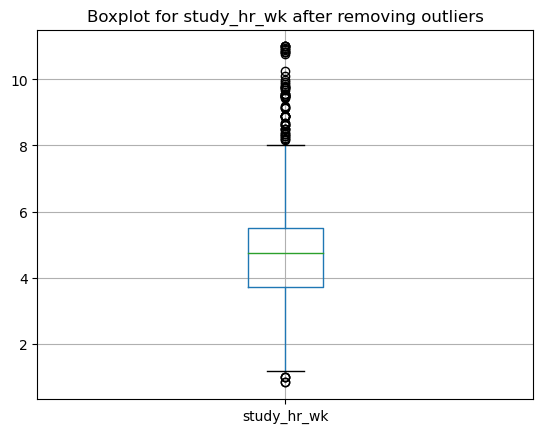

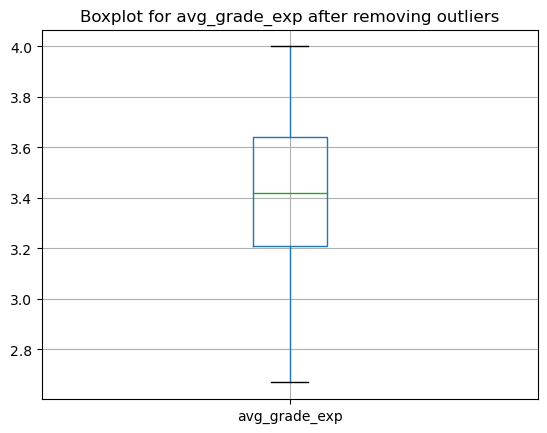


Outliers Removed:
 {'total_seats': 37, 'class_length': 1, 'enroll': 26, 'evals_made': 45, 'rcmd_class': 0, 'rcmd_instr': 24, 'study_hr_wk': 22, 'avg_grade_exp': 1, 'avg_grade_rec': 5, 'capacity_utilization': 33}


In [23]:
# Remove outliers that are more than three standard deviations away from the mean
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
outliers_removed = {}

# Select one or two columns for boxplots
columns_for_boxplot = ['study_hr_wk', 'avg_grade_exp']  # Example columns

for col in numerical_columns:
    mean = data[col].mean()
    std_dev = data[col].std()
    outliers = (data[col] - mean).abs() > (3 * std_dev)
    outliers_removed[col] = outliers.sum()
    data = data[~outliers]

    if col in columns_for_boxplot:
        # Optionally, visualize the boxplot after outlier removal
        data.boxplot(column=col)
        plt.title(f'Boxplot for {col} after removing outliers')
        plt.show()

# Print the number of outliers removed for each column
print("\nOutliers Removed:\n", outliers_removed)

> Ensure text fields are clean (check and remove possible whitespace existed in text)

In [24]:
whitespace_removed = {}

text_columns = data.select_dtypes(include=['object']).columns
for col in text_columns:
    whitespace_count = data[col].str.count(r'^\s+|\s+$').sum()
    whitespace_removed[col] = whitespace_count
    data[col] = data[col].str.strip()

print("\nWhitespace Removed:\n", whitespace_removed)


Whitespace Removed:
 {'sub_course': 0, 'class_schedule': 0, 'department_name': 0}


In [25]:
final_cleaned_file_path = 'SP22_cleaned.csv'
data.to_csv(final_cleaned_file_path, index=False)

## Exploratory Data Analysis (EDA)

> **Histograms** for numerical columns in subplots

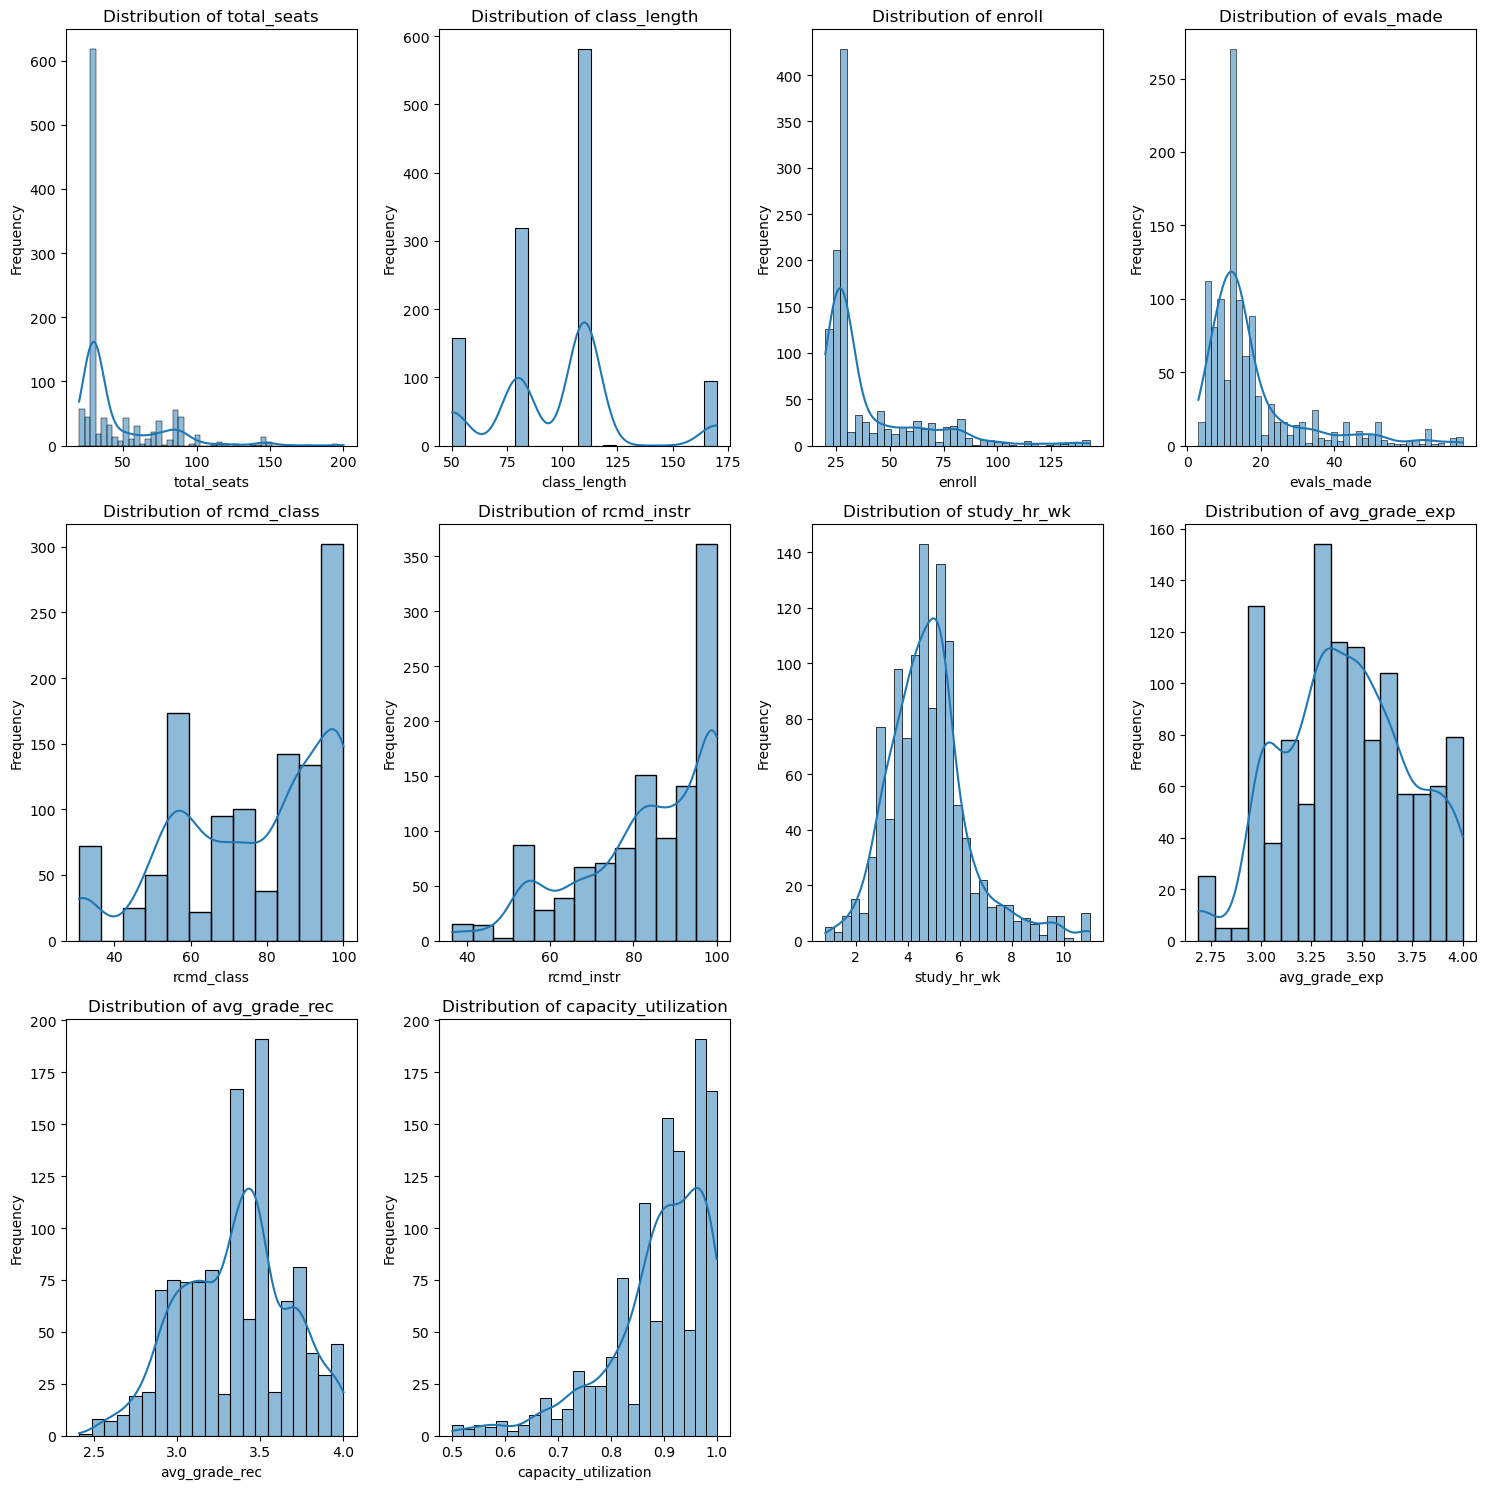

In [26]:
numerical_columns = data.select_dtypes(include=['float64']).columns

n_cols = 4
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(numerical_columns):
    row = i // n_cols
    col_pos = i % n_cols
    sns.histplot(data[col], kde=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

> Correlation matrix

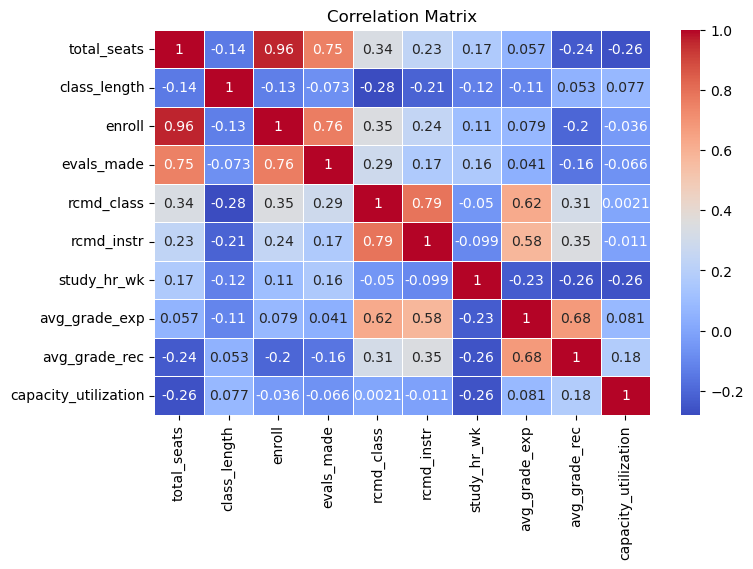

In [27]:
# Compute and visualize the correlation matrix
numerical_columns = data.select_dtypes(include=['float64']).columns
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

> Categorical Analysis

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153 entries, 1 to 6851
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sub_course            1153 non-null   object 
 1   total_seats           1153 non-null   float64
 2   class_schedule        1153 non-null   object 
 3   class_length          1153 non-null   float64
 4   enroll                1153 non-null   float64
 5   evals_made            1153 non-null   float64
 6   rcmd_class            1153 non-null   float64
 7   rcmd_instr            1153 non-null   float64
 8   study_hr_wk           1153 non-null   float64
 9   avg_grade_exp         1153 non-null   float64
 10  avg_grade_rec         1153 non-null   float64
 11  department_name       1153 non-null   object 
 12  capacity_utilization  1153 non-null   float64
dtypes: float64(10), object(3)
memory usage: 126.1+ KB


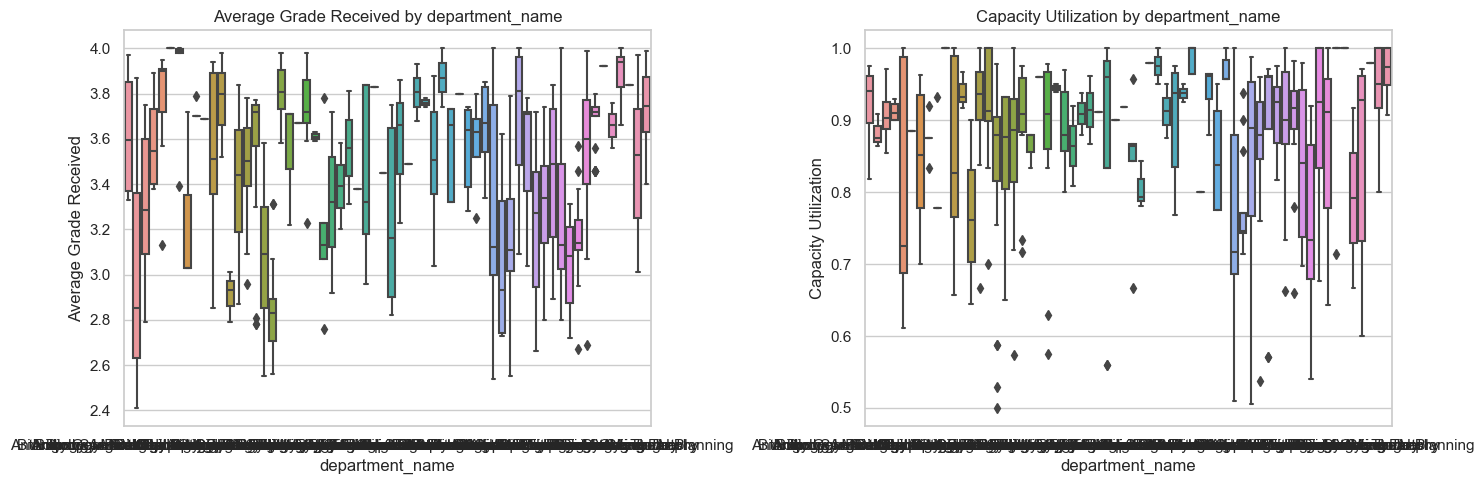

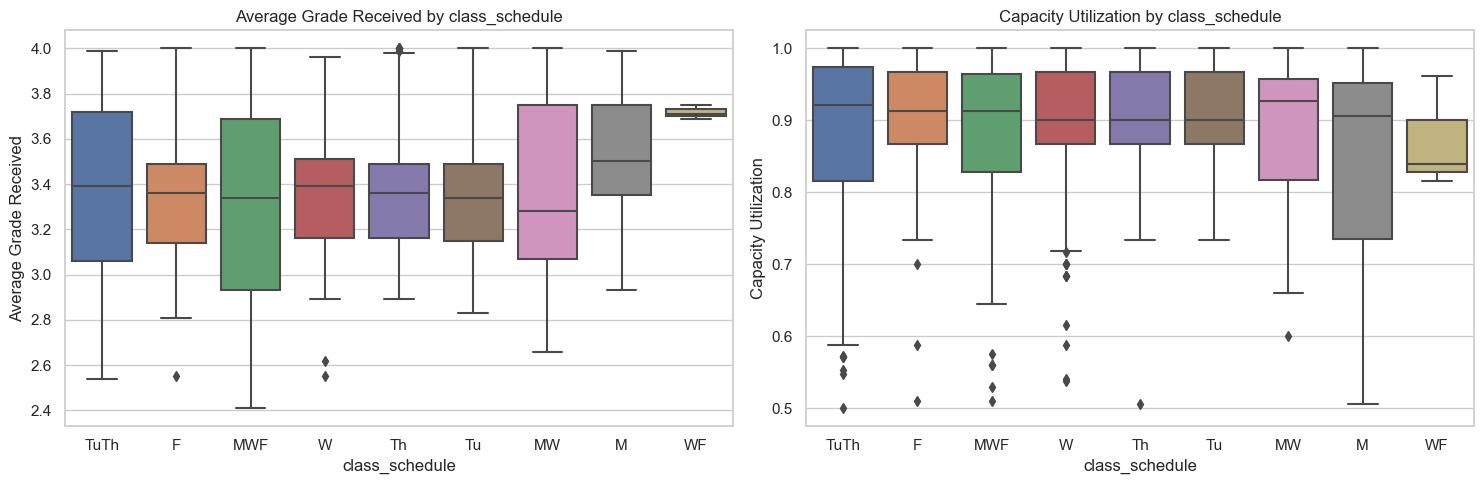

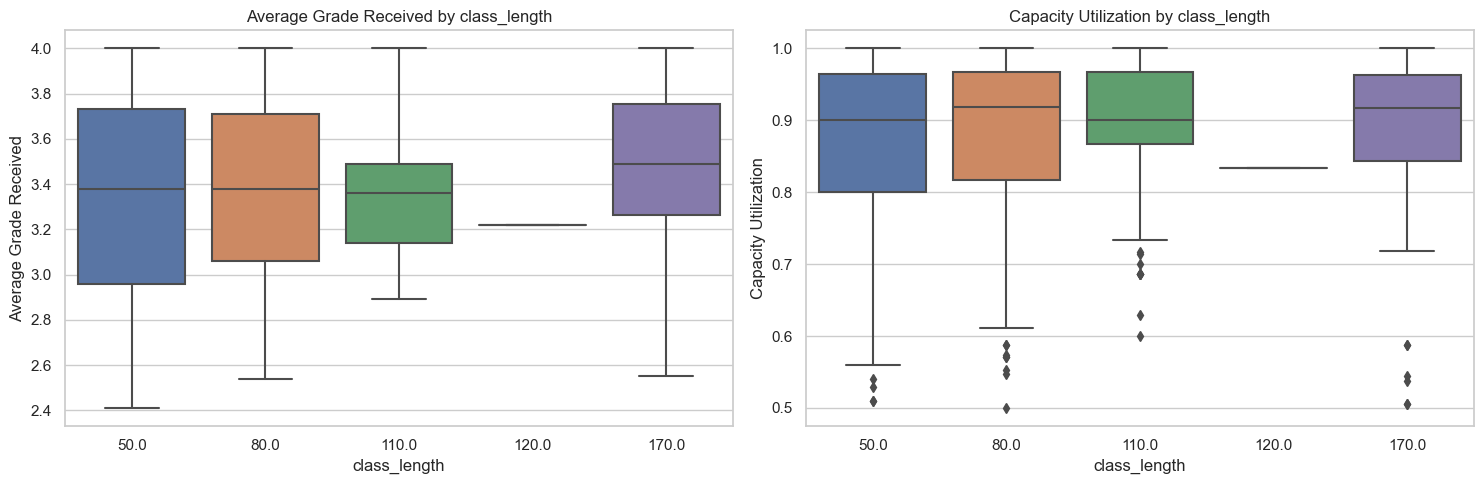

In [29]:
# Plot settings
sns.set(style="whitegrid")

# Define a function to create the boxplots
def plot_categorical_analysis(df, cat_var):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot avg_grade_rec distribution
    sns.boxplot(x=cat_var, y='avg_grade_rec', data=df, ax=axes[0])
    axes[0].set_title(f'Average Grade Received by {cat_var}')
    axes[0].set_xlabel(cat_var)
    axes[0].set_ylabel('Average Grade Received')

    # Plot capacity_utilization distribution
    sns.boxplot(x=cat_var, y='capacity_utilization', data=df, ax=axes[1])
    axes[1].set_title(f'Capacity Utilization by {cat_var}')
    axes[1].set_xlabel(cat_var)
    axes[1].set_ylabel('Capacity Utilization')

    plt.tight_layout()
    plt.show()

# Plot for department_name
plot_categorical_analysis(data, 'department_name')

# Plot for class_schedule
plot_categorical_analysis(data, 'class_schedule')

# Plot for class_length
plot_categorical_analysis(data, 'class_length')

> Pair Plot

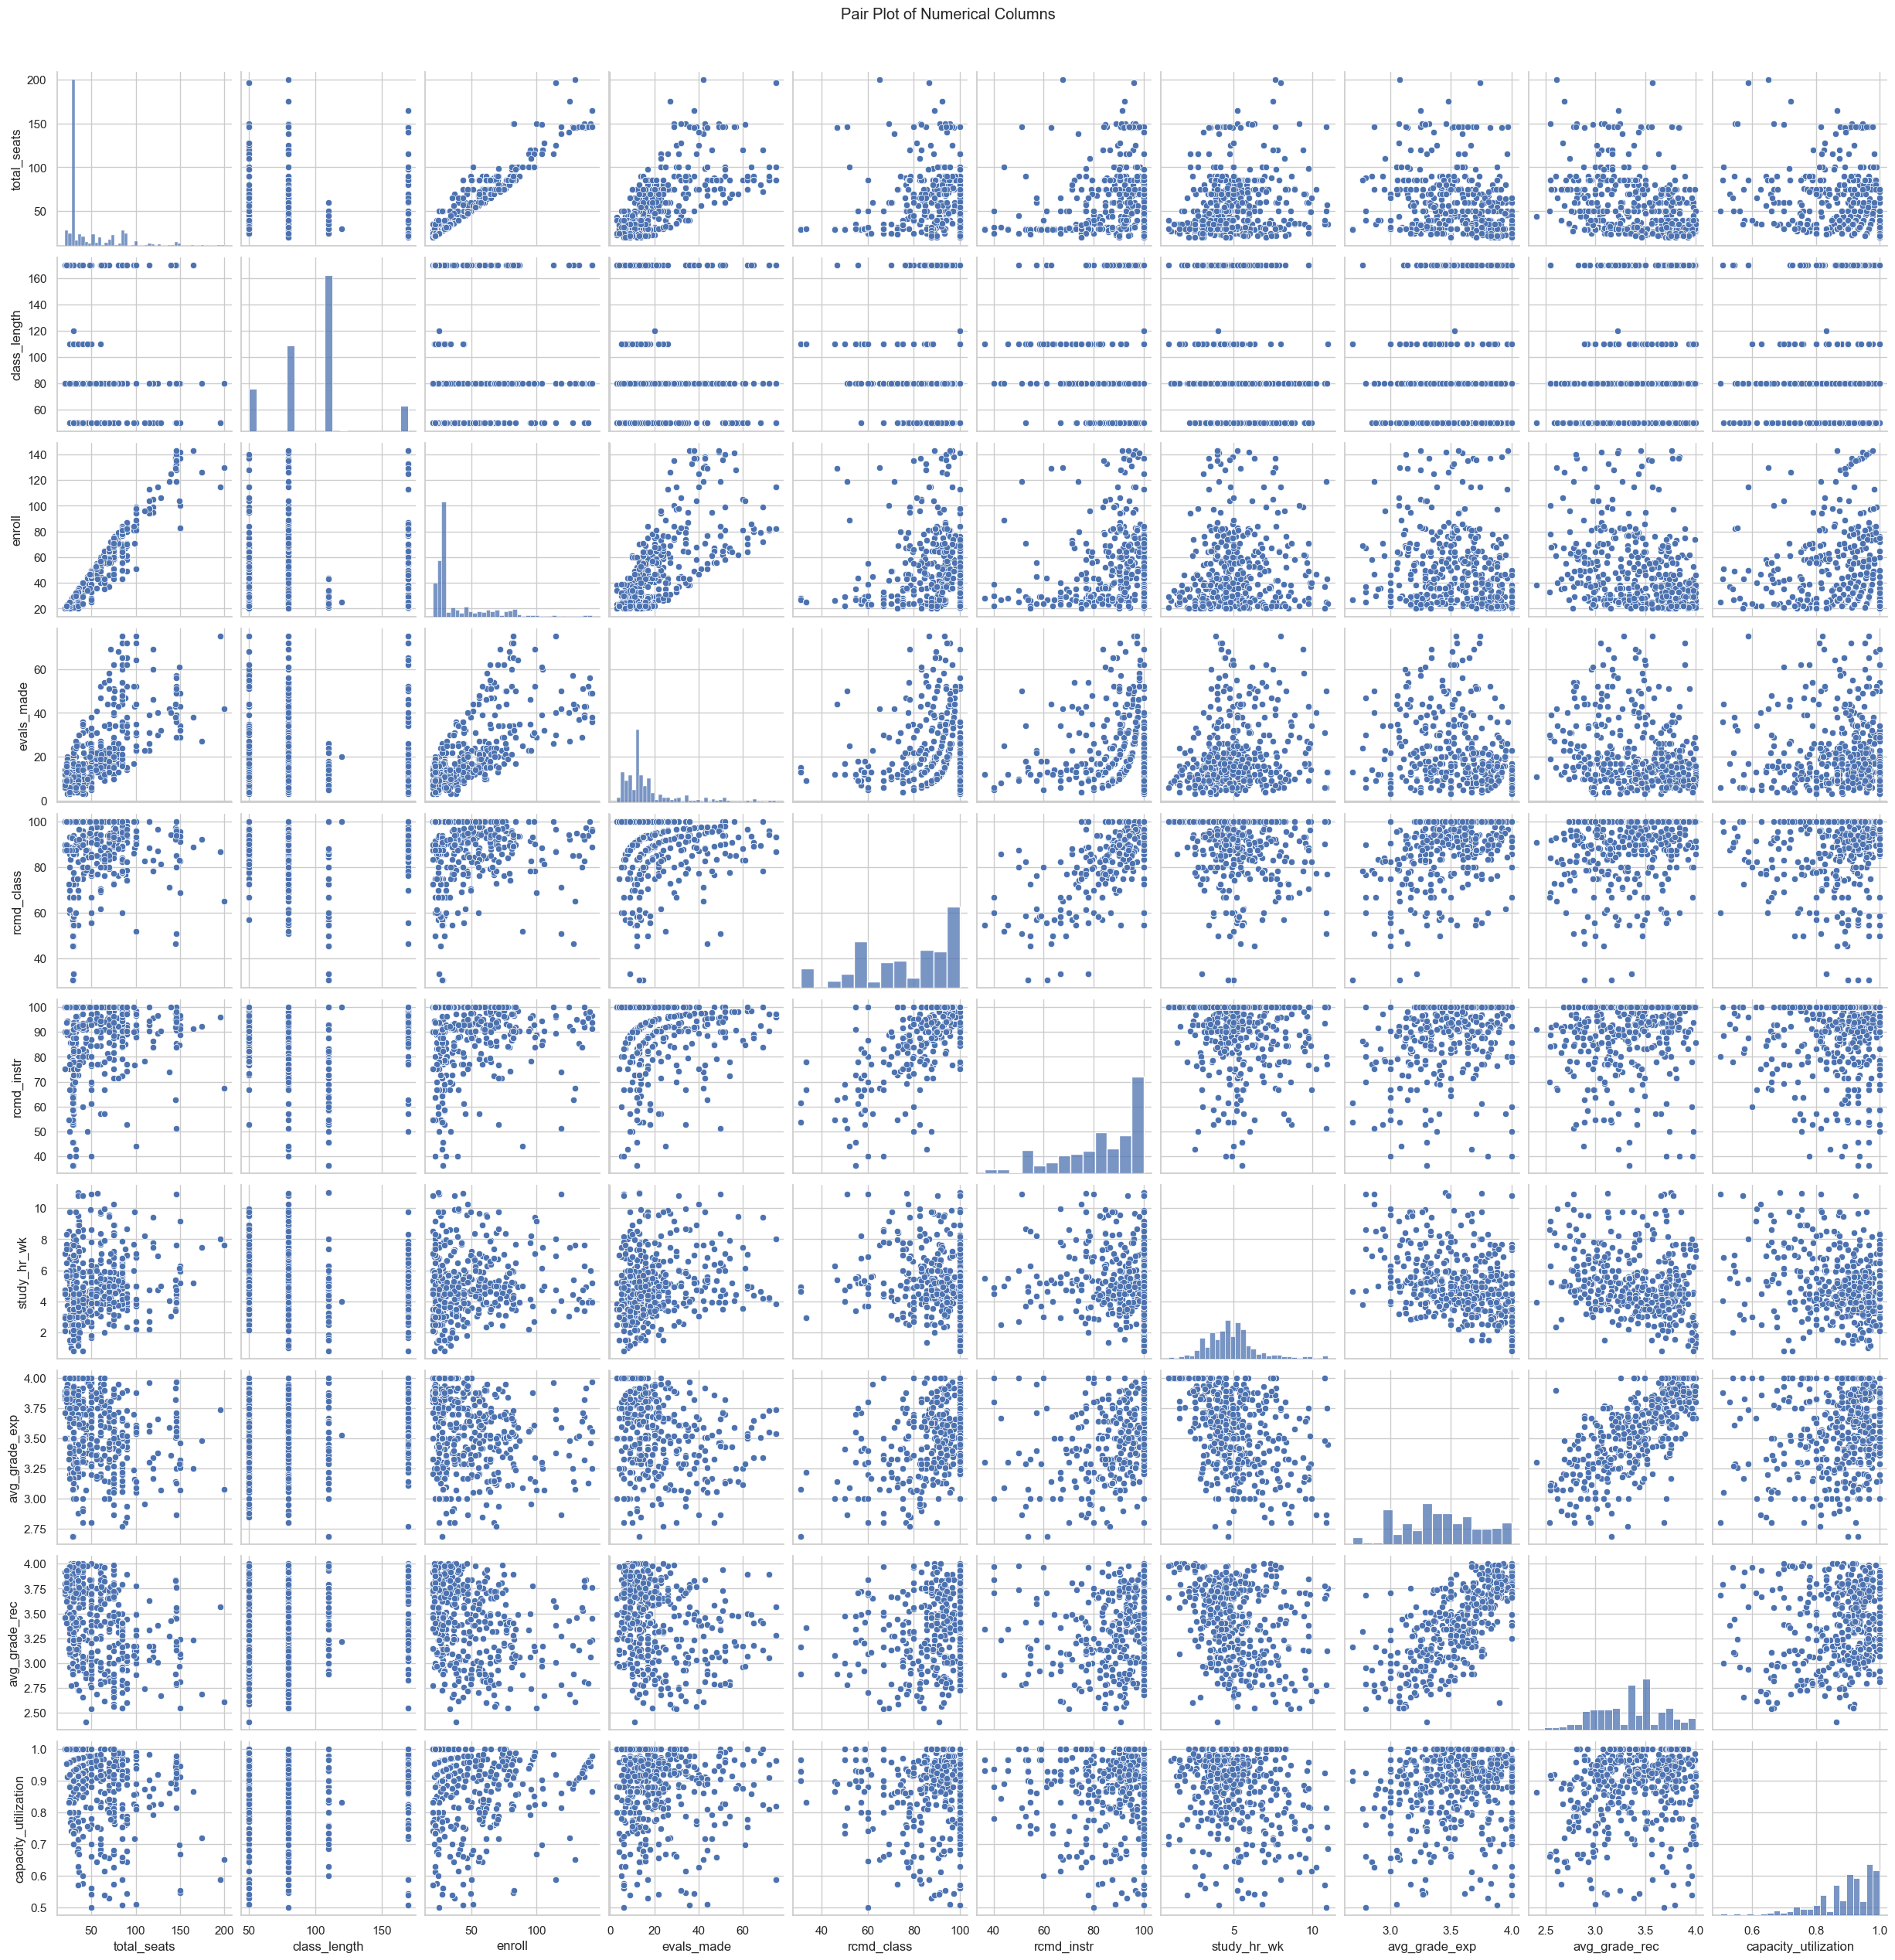

In [30]:
# Create pair plots for numerical columns
sns.pairplot(data[numerical_columns])
plt.suptitle('Pair Plot of Numerical Columns', y=1.02)
plt.show()

## Hypothesis Testing
### ANOVA Test for Differences in Capacity Utilization Across Departments:
To assess whether there is a statistically significant variation in capacity utilization across different departments at UC San Diego, we employ ANOVA (Analysis of Variance):

- Null Hypothesis (H0): There is no significant difference in capacity utilization across departments.

- Alternative Hypothesis (Ha): There is a significant difference in capacity utilization across departments.

Test Statistics: We use the ANOVA F-statistic as our test statistic for this analysis. The ANOVA F-statistic is particularly suited for comparing the means of more than two groups simultaneously by analyzing the variance within each group compared to the variance between the groups.

Significance Level: We set a significance level at 5% for this test. If the p-value is less than 0.05, we reject the null hypothesis, indicating that at least one department has a significantly different capacity utilization rate compared to others.

ANOVA Test Execution:
We will compute the F-statistic and p-value using the 'capacity_utilization' across different 'department_name' groups in our data.


In [56]:
# Expanded Statistical Analysis
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# ANOVA Test for Capacity Utilization Across Departments
# Extracting unique departments and their capacity utilization values
departments = data['department_name'].unique()
grouped_data = [data[data['department_name'] == dept]['capacity_utilization'] for dept in departments]

# Performing ANOVA
anova_results = stats.f_oneway(*grouped_data)
print(f"ANOVA results: F-statistic = {anova_results.statistic:.2f}, p-value = {anova_results.pvalue:.10f}")


ANOVA results: F-statistic = 4.65, p-value = 0.0000000000


### Statistical Analysis: ANOVA on Capacity Utilization Across Departments

The ANOVA (Analysis of Variance) test was conducted to determine if there are statistically significant differences in capacity utilization among the various departments at UCSD. The F-statistic from the ANOVA results is approximately 4.65, and the p-value is exceedingly small (practically zero), indicating strong statistical evidence.

#### Interpretation:
- **F-statistic**: The F-statistic value of 4.65 suggests that the between-group variability (differences in capacity utilization among departments) is larger than the within-group variability (variations within each department). This difference in variances is statistically significant.

- **P-value**: A p-value of 0.0000000000 signifies that the observed data is highly unlikely under the null hypothesis. In the context of our analysis, this implies a strong rejection of the null hypothesis that the capacity utilization is consistent across all departments.

#### Conclusion:
Given the very low p-value we found, we reject the null hypothesis and accept the alternative hypothesis that there are significant differences in capacity utilization across departments. This result prompts further investigation into specific departmental differences and suggests that resource allocation strategies may need to be department-specific to be effective.